# Description

(Please, take a look at the README.md file in this directory for instructions on how to run this notebook)

This notebook reads all gene correlations across all chromosomes and computes a single correlation matrix by assembling a big correlation matrix with all genes.

# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle

import numpy as np
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import conf
from entity import Gene

# Settings

In [3]:
# a cohort name (it could be something like UK_BIOBANK, etc)
COHORT_NAME = None

# reference panel such as 1000G or GTEX_V8
REFERENCE_PANEL = None

# predictions models such as MASHR or ELASTIC_NET
EQTL_MODEL = None

In [4]:
# Parameters
COHORT_NAME = "1000G_EUR"
REFERENCE_PANEL = "1000G"
EQTL_MODEL = "MASHR"


In [5]:
assert COHORT_NAME is not None and len(COHORT_NAME) > 0, "A cohort name must be given"

COHORT_NAME = COHORT_NAME.lower()
display(f"Cohort name: {COHORT_NAME}")

'Cohort name: 1000g_eur'

In [6]:
assert (
    REFERENCE_PANEL is not None and len(REFERENCE_PANEL) > 0
), "A reference panel must be given"

display(f"Reference panel: {REFERENCE_PANEL}")

'Reference panel: 1000G'

In [7]:
assert (
    EQTL_MODEL is not None and len(EQTL_MODEL) > 0
), "A prediction/eQTL model must be given"

EQTL_MODEL_FILES_PREFIX = conf.PHENOMEXCAN["PREDICTION_MODELS"][f"{EQTL_MODEL}_PREFIX"]
display(f"eQTL model: {EQTL_MODEL}) / {EQTL_MODEL_FILES_PREFIX}")

'eQTL model: MASHR) / mashr_'

In [8]:
OUTPUT_DIR_BASE = (
    conf.RESULTS["GLS"]
    / "gene_corrs"
    / "cohorts"
    / COHORT_NAME.lower()
    / REFERENCE_PANEL.lower()
    / EQTL_MODEL.lower()
)
OUTPUT_DIR_BASE.mkdir(parents=True, exist_ok=True)

display(f"Using output dir base: {OUTPUT_DIR_BASE}")

'Using output dir base: /opt/data/results/gls/gene_corrs/cohorts/1000g_eur/1000g/mashr'

In [9]:
COHORT_INPUT_DIR = conf.RESULTS["GLS"] / "gene_corrs" / "cohorts" / COHORT_NAME

display(f"Cohort input dir: {COHORT_INPUT_DIR}")
assert COHORT_INPUT_DIR.exists()

'Cohort input dir: /opt/data/results/gls/gene_corrs/cohorts/1000g_eur'

In [10]:
INPUT_DIR = OUTPUT_DIR_BASE / "by_chr"

display(f"Gene correlations input dir: {INPUT_DIR}")
assert INPUT_DIR.exists()

'Gene correlations input dir: /opt/data/results/gls/gene_corrs/cohorts/1000g_eur/1000g/mashr/by_chr'

# Load data

## Gene correlations

In [11]:
all_gene_corr_files = list(INPUT_DIR.glob("gene_corrs-chr*.pkl"))

In [12]:
# sort by chromosome
all_gene_corr_files = sorted(
    all_gene_corr_files, key=lambda x: int(x.name.split("-chr")[1].split(".pkl")[0])
)

In [13]:
len(all_gene_corr_files)

22

In [14]:
all_gene_corr_files

[PosixPath('/opt/data/results/gls/gene_corrs/cohorts/1000g_eur/1000g/mashr/by_chr/gene_corrs-chr1.pkl'),
 PosixPath('/opt/data/results/gls/gene_corrs/cohorts/1000g_eur/1000g/mashr/by_chr/gene_corrs-chr2.pkl'),
 PosixPath('/opt/data/results/gls/gene_corrs/cohorts/1000g_eur/1000g/mashr/by_chr/gene_corrs-chr3.pkl'),
 PosixPath('/opt/data/results/gls/gene_corrs/cohorts/1000g_eur/1000g/mashr/by_chr/gene_corrs-chr4.pkl'),
 PosixPath('/opt/data/results/gls/gene_corrs/cohorts/1000g_eur/1000g/mashr/by_chr/gene_corrs-chr5.pkl'),
 PosixPath('/opt/data/results/gls/gene_corrs/cohorts/1000g_eur/1000g/mashr/by_chr/gene_corrs-chr6.pkl'),
 PosixPath('/opt/data/results/gls/gene_corrs/cohorts/1000g_eur/1000g/mashr/by_chr/gene_corrs-chr7.pkl'),
 PosixPath('/opt/data/results/gls/gene_corrs/cohorts/1000g_eur/1000g/mashr/by_chr/gene_corrs-chr8.pkl'),
 PosixPath('/opt/data/results/gls/gene_corrs/cohorts/1000g_eur/1000g/mashr/by_chr/gene_corrs-chr9.pkl'),
 PosixPath('/opt/data/results/gls/gene_corrs/cohorts/10

In [15]:
assert len(all_gene_corr_files) == 22

## Get common genes

In [16]:
gene_ids = set()
for f in all_gene_corr_files:
    chr_genes = pd.read_pickle(f).index.tolist()
    gene_ids.update(chr_genes)

In [17]:
display(len(gene_ids))

6442

In [18]:
sorted(list(gene_ids))[:5]

['ENSG00000000419',
 'ENSG00000000938',
 'ENSG00000000971',
 'ENSG00000001084',
 'ENSG00000001167']

## Gene info

In [19]:
genes_info = pd.read_pickle(COHORT_INPUT_DIR / "genes_info.pkl")

In [20]:
genes_info.shape

(6444, 7)

In [21]:
genes_info.head()

,name,id,chr,band,start_position,end_position,gene_length
0,MFN2,ENSG00000116688,1,1p36.22,11980181.0,12013514.0,33333.0
1,PPA2,ENSG00000138777,4,4q24,105369077.0,105474067.0,104990.0
2,ADRA2A,ENSG00000150594,10,10q25.2,111077163.0,111080907.0,3744.0
3,RYR2,ENSG00000198626,1,1q43,237042184.0,237833988.0,791804.0
4,VAV2,ENSG00000160293,9,9q34.2,133761894.0,133992604.0,230710.0


In [22]:
# keep genes in correlation matrices only
genes_info = genes_info[genes_info["id"].isin(gene_ids)]

In [23]:
genes_info.shape

(6442, 7)

In [24]:
assert not genes_info.isna().any().any()

In [25]:
genes_info.dtypes

name               object
id                 object
chr                object
band               object
start_position    float64
end_position      float64
gene_length       float64
dtype: object

In [26]:
genes_info["chr"] = genes_info["chr"].apply(pd.to_numeric, downcast="integer")
genes_info["start_position"] = genes_info["start_position"].astype(int)
genes_info["end_position"] = genes_info["end_position"].astype(int)
genes_info["gene_length"] = genes_info["gene_length"].astype(int)

In [27]:
genes_info.dtypes

name              object
id                object
chr                int64
band              object
start_position     int64
end_position       int64
gene_length        int64
dtype: object

In [28]:
assert not genes_info.isna().any(None)

In [29]:
genes_info.head()

,name,id,chr,band,start_position,end_position,gene_length
0,MFN2,ENSG00000116688,1,1p36.22,11980181,12013514,33333
1,PPA2,ENSG00000138777,4,4q24,105369077,105474067,104990
2,ADRA2A,ENSG00000150594,10,10q25.2,111077163,111080907,3744
3,RYR2,ENSG00000198626,1,1q43,237042184,237833988,791804
4,VAV2,ENSG00000160293,9,9q34.2,133761894,133992604,230710


# Create full correlation matrix

In [30]:
genes_info = genes_info.sort_values(["chr", "start_position"])

In [31]:
genes_info

,name,id,chr,band,start_position,end_position,gene_length
3661,NOC2L,ENSG00000188976,1,1p36.33,944203,959309,15106
5620,HES4,ENSG00000188290,1,1p36.33,998962,1000172,1210
192,ISG15,ENSG00000187608,1,1p36.33,1001138,1014540,13402
2239,AGRN,ENSG00000188157,1,1p36.33,1020120,1056118,35998
5164,TNFRSF18,ENSG00000186891,1,1p36.33,1203508,1206592,3084
...,...,...,...,...,...,...,...
2566,CPT1B,ENSG00000205560,22,22q13.33,50568861,50578465,9604
2722,CHKB,ENSG00000100288,22,22q13.33,50578949,50601455,22506
899,MAPK8IP2,ENSG00000008735,22,22q13.33,50600793,50613981,13188
1926,ARSA,ENSG00000100299,22,22q13.33,50622754,50628173,5419


In [32]:
full_corr_matrix = pd.DataFrame(
    np.zeros((genes_info.shape[0], genes_info.shape[0])),
    index=genes_info["id"].tolist(),
    columns=genes_info["id"].tolist(),
)

In [33]:
assert full_corr_matrix.index.is_unique & full_corr_matrix.columns.is_unique

In [34]:
for chr_corr_file in all_gene_corr_files:
    print(chr_corr_file.name, flush=True)

    corr_data = pd.read_pickle(chr_corr_file)
    full_corr_matrix.loc[corr_data.index, corr_data.columns] = corr_data

gene_corrs-chr1.pkl
gene_corrs-chr2.pkl
gene_corrs-chr3.pkl
gene_corrs-chr4.pkl
gene_corrs-chr5.pkl
gene_corrs-chr6.pkl
gene_corrs-chr7.pkl
gene_corrs-chr8.pkl
gene_corrs-chr9.pkl
gene_corrs-chr10.pkl
gene_corrs-chr11.pkl
gene_corrs-chr12.pkl
gene_corrs-chr13.pkl
gene_corrs-chr14.pkl
gene_corrs-chr15.pkl
gene_corrs-chr16.pkl
gene_corrs-chr17.pkl
gene_corrs-chr18.pkl
gene_corrs-chr19.pkl
gene_corrs-chr20.pkl
gene_corrs-chr21.pkl
gene_corrs-chr22.pkl


In [35]:
full_corr_matrix.shape

(6442, 6442)

In [36]:
full_corr_matrix.head()

,ENSG00000188976,ENSG00000188290,ENSG00000187608,ENSG00000188157,ENSG00000186891,ENSG00000186827,ENSG00000176022,ENSG00000160087,ENSG00000131584,ENSG00000169962,...,ENSG00000196576,ENSG00000128165,ENSG00000100253,ENSG00000130489,ENSG00000025708,ENSG00000205560,ENSG00000100288,ENSG00000008735,ENSG00000100299,ENSG00000251322
ENSG00000188976,1.000000,0.115011,0.173138,0.056096,0.008032,0.008727,0.006797,0.004533,0.007350,0.010391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000188290,0.115011,1.000000,0.681368,0.360588,0.011545,0.010729,0.003577,0.010230,0.010747,0.008769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000187608,0.173138,0.681368,1.000000,0.381394,0.011774,0.012527,0.003754,0.012096,0.012679,0.010442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000188157,0.056096,0.360588,0.381394,1.000000,0.013005,0.015775,0.006184,0.006813,0.010775,0.009189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSG00000186891,0.008032,0.011545,0.011774,0.013005,1.000000,0.356676,0.454010,0.137643,0.200340,0.093210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
np.all(full_corr_matrix.to_numpy().diagonal() == 1.0)

True

## Some checks

In [38]:
assert not full_corr_matrix.isna().any(None)
assert not np.isinf(full_corr_matrix.to_numpy()).any()
assert not np.iscomplex(full_corr_matrix.to_numpy()).any()

In [39]:
_min_val = full_corr_matrix.min().min()
display(_min_val)
assert _min_val >= 0.0

0.0

In [40]:
_max_val = full_corr_matrix.max().max()  # this will capture the 1.0 in the diagonal
display(_max_val)
assert _max_val <= 1.00

1.0

# Positive definiteness

In [41]:
# print negative eigenvalues
eigs = np.linalg.eigvals(full_corr_matrix.to_numpy())
display(len(eigs[eigs < 0]))
display(eigs[eigs < 0])

1

array([-1.11100854e-15])

In [42]:
CHOL_DECOMPOSITION_FAILED = None

try:
    chol_mat = np.linalg.cholesky(full_corr_matrix.to_numpy())
    cov_inv = np.linalg.inv(chol_mat)
    print("Works!")
    CHOL_DECOMPOSITION_FAILED = False
except Exception as e:
    print(f"Cholesky decomposition failed: {str(e)}")
    CHOL_DECOMPOSITION_FAILED = True

Cholesky decomposition failed: Matrix is not positive definite


## Adjust

In [43]:
%load_ext rpy2.ipython

In [44]:
%%R
# taken and adapted from https://www.r-bloggers.com/2013/08/correcting-a-pseudo-correlation-matrix-to-be-positive-semidefinite/
CorrectCM <- function(CM, p = 0) {
  n <- dim(CM)[1L]
  E <- eigen(CM)
  CM1 <- E$vectors %*% tcrossprod(diag(pmax(E$values, p), n), E$vectors)
  Balance <- diag(1 / sqrt(diag(CM1)))
  CM2 <- Balance %*% CM1 %*% Balance
  return(CM2)
}

In [45]:
if CHOL_DECOMPOSITION_FAILED:
    corr_mat_r = full_corr_matrix.to_numpy()

    %Rpush corr_mat_r
    %R -o corr_mat_r_fixed corr_mat_r_fixed <- CorrectCM(corr_mat_r, 1e-5)

    display(corr_mat_r_fixed.shape)

    full_corr_matrix_fixed = pd.DataFrame(
        corr_mat_r_fixed,
        index=full_corr_matrix.index.copy(),
        columns=full_corr_matrix.columns.copy(),
    )
    display(full_corr_matrix_fixed.shape)
    display(full_corr_matrix_fixed)
else:
    print("No adjustment was necessary")

(6442, 6442)

(6442, 6442)

,ENSG00000188976,ENSG00000188290,ENSG00000187608,ENSG00000188157,ENSG00000186891,ENSG00000186827,ENSG00000176022,ENSG00000160087,ENSG00000131584,ENSG00000169962,...,ENSG00000196576,ENSG00000128165,ENSG00000100253,ENSG00000130489,ENSG00000025708,ENSG00000205560,ENSG00000100288,ENSG00000008735,ENSG00000100299,ENSG00000251322
ENSG00000188976,1.000000,0.115011,0.173138,0.056096,0.008032,0.008727,0.006797,0.004533,0.007350,0.010391,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000188290,0.115011,1.000000,0.681368,0.360588,0.011545,0.010729,0.003577,0.010230,0.010747,0.008769,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000187608,0.173138,0.681368,1.000000,0.381394,0.011774,0.012527,0.003754,0.012096,0.012679,0.010442,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000188157,0.056096,0.360588,0.381394,1.000000,0.013005,0.015775,0.006184,0.006813,0.010775,0.009189,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000186891,0.008032,0.011545,0.011774,0.013005,1.000000,0.356676,0.454010,0.137643,0.200340,0.093210,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000205560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.016479,0.065197,0.008608,0.293494,0.233187,1.000000,0.732548,0.197890,0.036229,0.008387
ENSG00000100288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.022149,0.061143,0.011177,0.240853,0.211789,0.732548,1.000000,0.280542,0.027155,0.020439
ENSG00000008735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.040192,0.097400,0.067715,0.070062,0.132700,0.197890,0.280542,1.000000,0.226706,0.035740
ENSG00000100299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.013862,0.028588,0.013744,0.037442,0.041831,0.036229,0.027155,0.226706,1.000000,0.032019


## Make sure the new matrix is positive definite

In [46]:
if CHOL_DECOMPOSITION_FAILED:
    # print negative eigenvalues
    eigs = np.linalg.eigvals(full_corr_matrix_fixed.to_numpy())
    display(len(eigs[eigs < 0]))
    display(eigs[eigs < 0])

    chol_mat = np.linalg.cholesky(full_corr_matrix_fixed.to_numpy())
    cov_inv = np.linalg.inv(chol_mat)

    assert not np.isnan(chol_mat).any()
    assert not np.isinf(chol_mat).any()
    assert not np.iscomplex(chol_mat).any()

    assert not np.isnan(cov_inv).any()
    assert not np.isinf(cov_inv).any()
    assert not np.iscomplex(cov_inv).any()
else:
    print("No adjustment was necessary")

0

array([], dtype=float64)

## Compare adjusted and original correlation matrix

In [47]:
if CHOL_DECOMPOSITION_FAILED:
    # print the element-wise difference between the original and the adjusted matrix
    _diff = ((full_corr_matrix - full_corr_matrix_fixed) ** 2).unstack().sum()
    display(_diff)
    assert _diff < 1e-5
else:
    print("No adjustment was necessary")

4.140139545867525e-10

## Replace original matrix with adjusted one

In [48]:
if CHOL_DECOMPOSITION_FAILED:
    full_corr_matrix = full_corr_matrix_fixed
else:
    print("No adjustment was necessary")

# Stats

In [49]:
full_corr_matrix_flat = full_corr_matrix.mask(
    np.triu(np.ones(full_corr_matrix.shape)).astype(bool)
).stack()

In [50]:
display(full_corr_matrix_flat.shape)
assert full_corr_matrix_flat.shape[0] == int(
    full_corr_matrix.shape[0] * (full_corr_matrix.shape[0] - 1) / 2
)

(20746461,)

## On all correlations

In [51]:
_corr_mat = full_corr_matrix_flat

In [52]:
_corr_mat.shape

(20746461,)

In [53]:
_corr_mat.head()

ENSG00000188290  ENSG00000188976    0.115011
ENSG00000187608  ENSG00000188976    0.173138
                 ENSG00000188290    0.681368
ENSG00000188157  ENSG00000188976    0.056096
                 ENSG00000188290    0.360588
dtype: float64

In [54]:
_corr_mat.describe().apply(str)

count               20746461.0
mean     0.0005816522085921089
std      0.0071792813860001034
min                        0.0
25%                        0.0
50%                        0.0
75%                        0.0
max         0.9999900000499998
dtype: object

In [55]:
display(_corr_mat.quantile(np.arange(0, 1, 0.05)))

0.00    0.000000
0.05    0.000000
0.10    0.000000
0.15    0.000000
0.20    0.000000
0.25    0.000000
0.30    0.000000
0.35    0.000000
0.40    0.000000
0.45    0.000000
0.50    0.000000
0.55    0.000000
0.60    0.000000
0.65    0.000000
0.70    0.000000
0.75    0.000000
0.80    0.000000
0.85    0.000000
0.90    0.000000
0.95    0.003199
dtype: float64

In [56]:
display(_corr_mat.quantile(np.arange(0, 0.001, 0.0001)))

0.0000    0.0
0.0001    0.0
0.0002    0.0
0.0003    0.0
0.0004    0.0
0.0005    0.0
0.0006    0.0
0.0007    0.0
0.0008    0.0
0.0009    0.0
dtype: float64

In [57]:
display(_corr_mat.quantile(np.arange(0.999, 1.0, 0.0001)))

0.9990    0.021681
0.9991    0.022703
0.9992    0.024414
0.9993    0.028023
0.9994    0.036368
0.9995    0.051164
0.9996    0.078884
0.9997    0.133181
0.9998    0.234881
0.9999    0.392450
1.0000    0.999990
dtype: float64

### Plot: distribution

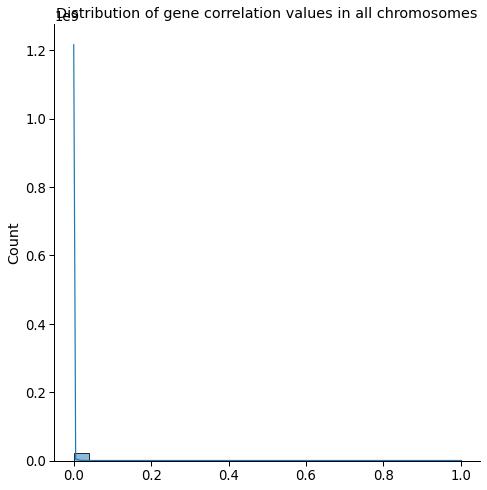

In [58]:
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.displot(_corr_mat, kde=True, height=7)
    g.ax.set_title("Distribution of gene correlation values in all chromosomes")

### Plot: heatmap

In [59]:
vmin_val = 0.0
vmax_val = max(0.05, _corr_mat.quantile(0.99))
display(f"{vmin_val} / {vmax_val}")

'0.0 / 0.05'

Text(0.5, 1.0, 'Gene correlations in all chromosomes')

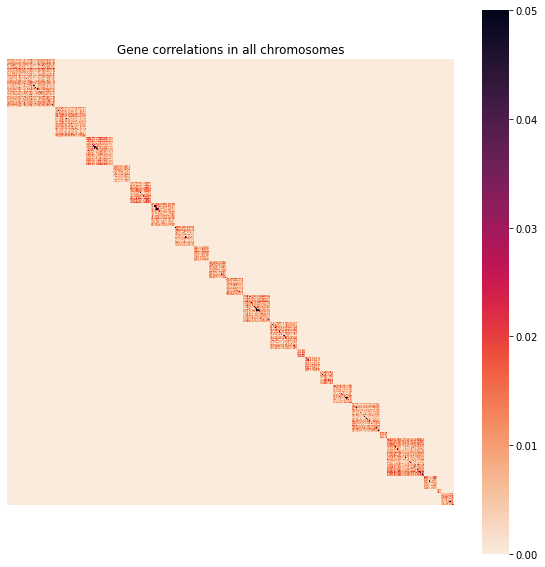

In [60]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    full_corr_matrix,
    xticklabels=False,
    yticklabels=False,
    square=True,
    vmin=vmin_val,
    vmax=vmax_val,
    cmap="rocket_r",
    ax=ax,
)
ax.set_title("Gene correlations in all chromosomes")

## On nonzero correlations

In [61]:
nonzero_corrs = full_corr_matrix_flat[full_corr_matrix_flat > 0.0]

In [62]:
_corr_mat = nonzero_corrs

In [63]:
_corr_mat.shape

(1175426,)

In [64]:
_corr_mat.head()

ENSG00000188290  ENSG00000188976    0.115011
ENSG00000187608  ENSG00000188976    0.173138
                 ENSG00000188290    0.681368
ENSG00000188157  ENSG00000188976    0.056096
                 ENSG00000188290    0.360588
dtype: float64

In [65]:
_corr_mat.describe().apply(str)

count                 1175426.0
mean       0.010266256541134926
std        0.028465807032153165
min      1.6979022141093296e-11
25%        0.004974360832365826
50%        0.007725814268712206
75%         0.01089450488318943
max          0.9999900000499998
dtype: object

In [66]:
display(_corr_mat.quantile(np.arange(0, 1, 0.05)))

0.00    1.697902e-11
0.05    1.900950e-03
0.10    2.905345e-03
0.15    3.689235e-03
0.20    4.359856e-03
0.25    4.974361e-03
0.30    5.544995e-03
0.35    6.099808e-03
0.40    6.642283e-03
0.45    7.177706e-03
0.50    7.725814e-03
0.55    8.284770e-03
0.60    8.865867e-03
0.65    9.487110e-03
0.70    1.015237e-02
0.75    1.089450e-02
0.80    1.174918e-02
0.85    1.279266e-02
0.90    1.418922e-02
0.95    1.655567e-02
dtype: float64

In [67]:
display(_corr_mat.quantile(np.arange(0, 0.001, 0.0001)))

0.0000    1.697902e-11
0.0001    1.371332e-06
0.0002    4.637222e-06
0.0003    9.346197e-06
0.0004    1.453926e-05
0.0005    1.939051e-05
0.0006    2.594216e-05
0.0007    3.307698e-05
0.0008    3.995087e-05
0.0009    4.739880e-05
dtype: float64

In [68]:
display(_corr_mat.quantile(np.arange(0.999, 1.0, 0.0001)))

0.9990    0.497081
0.9991    0.514762
0.9992    0.536626
0.9993    0.560535
0.9994    0.581584
0.9995    0.611738
0.9996    0.640323
0.9997    0.671240
0.9998    0.721949
0.9999    0.803545
1.0000    0.999990
dtype: float64

### Plot: distribution

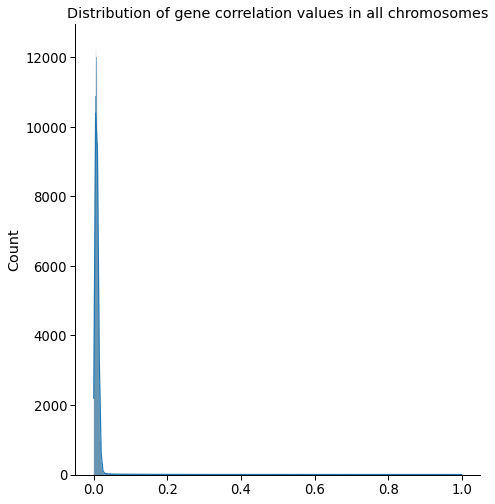

In [69]:
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.displot(_corr_mat, kde=True, height=7)
    g.ax.set_title("Distribution of gene correlation values in all chromosomes")

# Save

## With ensemble ids

## With gene symbols

In [70]:
output_file = OUTPUT_DIR_BASE / "gene_corrs-symbols.pkl"
display(output_file)

PosixPath('/opt/data/results/gls/gene_corrs/cohorts/1000g_eur/1000g/mashr/gene_corrs-symbols.pkl')

In [71]:
gene_corrs = full_corr_matrix.rename(
    index=Gene.GENE_ID_TO_NAME_MAP, columns=Gene.GENE_ID_TO_NAME_MAP
)

In [72]:
assert not gene_corrs.isna().any(None)
assert not np.isinf(gene_corrs.to_numpy()).any()
assert not np.iscomplex(gene_corrs.to_numpy()).any()

In [73]:
assert gene_corrs.index.is_unique
assert gene_corrs.columns.is_unique

In [74]:
gene_corrs.shape

(6442, 6442)

In [75]:
gene_corrs.head()

,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,B3GALT6,UBE2J2,ACAP3,TAS1R3,...,PLXNB2,ADM2,MIOX,SCO2,TYMP,CPT1B,CHKB,MAPK8IP2,ARSA,SHANK3
NOC2L,1.000000,0.115011,0.173138,0.056096,0.008032,0.008727,0.006797,0.004533,0.007350,0.010391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HES4,0.115011,1.000000,0.681368,0.360588,0.011545,0.010729,0.003577,0.010230,0.010747,0.008769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISG15,0.173138,0.681368,1.000000,0.381394,0.011774,0.012527,0.003754,0.012096,0.012679,0.010442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGRN,0.056096,0.360588,0.381394,1.000000,0.013005,0.015775,0.006184,0.006813,0.010775,0.009189,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TNFRSF18,0.008032,0.011545,0.011774,0.013005,1.000000,0.356676,0.454010,0.137643,0.200340,0.093210,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
gene_corrs.to_pickle(output_file)